## 6.1. 이미지 분류를 위한 신경망

### 6.1.1. LeNet-5

In [1]:
# (코드 6-1)
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim # 경사하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os # 파일 경로 함수 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현 (특히 모델 학습 경과 확인하고 싶을 때)
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\USER\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\USER\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# (코드 6-2) 이미지 데이터셋 전처리 (ex. 텐서 변환)
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# (코드 6-3) 이미지 데이터셋을 불러와서 훈련/검증/테스트로 분리
cat_directory = r'./data/dogs-vs-cats/Cat/'
dog_directory = r'./data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

# 개와 고양이 이미지들을 합쳐서 images_filepaths에 저장
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]
# 성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트 가능
# train_images_filepaths = correct_images_filepaths[:20000] 
# 이때 훈련과 함께 검증도 늘려줘야 함
# val_images_filepaths = correct_images_filepaths[20000:-10] 
  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

# 출력 보면 400 92 10 나옴 >> 훈련용 이미지 400개 / 검증용 이미지 92개 / 테스트용 이미지 10개

400 92 10


In [4]:
## 주어진 데이터셋을 훈련/검증/테스트 용도로 분리했음
## 테스트 용도의 데이터셋에 어떤 데이터 있는지 확인

# (코드 6-4) 테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        
        # 예측과 정답(레이블)이 동일하면 초록색으로 표시, 그렇지 않으면 빨간색으로 표시
        color = "green" if true_label == predicted_label else "red"
        
        ax.ravel()[i].imshow(image) # 개별 이미지 출력
        ax.ravel()[i].set_title(predicted_label, color=color) # predicted_label을 타이틀로 사용
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

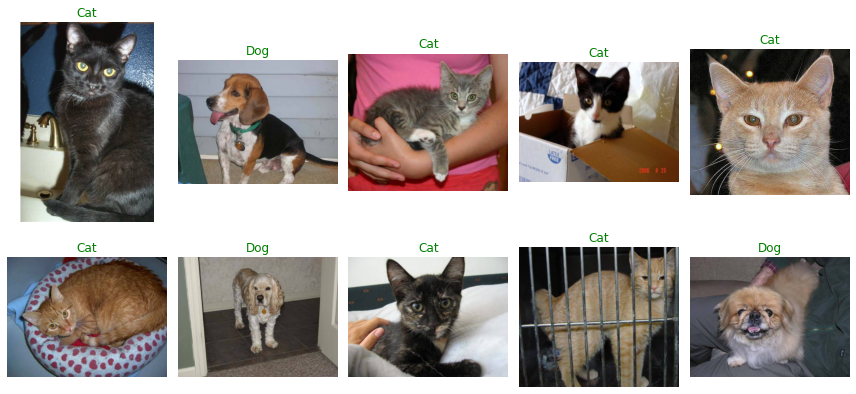

In [5]:
# (코드 6-5) 테스트 데이터셋 이미지 출력
display_image_grid(test_images_filepaths)

In [6]:
# 한꺼번에 전체 데이터를 불러오는 것이 아니라 배치 크기만큼 분할하여 가져옴
# 아래 생성한 DogvsCatDataset() 클래스 : 데이터를 불러오는 방법 정의
# 예제 목적: 다수의 개, 고양이 이미지가 포함된 데이터에서 이들을 예측
# 레이블(정답) 이미지에서 고양이, 개가 포함될 확률 코드로 구현
# 고양이 이미지 레이블 = 0 / 개 이미지 레이블 = 1 이 되도록 코드 구현

# (코드 6-6) 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
    # 데이터셋 번처리 (데이터 변형 적용)
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform # 클래스 호출할 때 transform에 대한 매개변수 받아옴
        self.phase = phase # train 적용
    
    # inage_filepaths 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.file_list)
    
    # 데이터셋에서 데이터를 가져오는 부분 (텐서 형태로 됨)
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [7]:
# (코드 6-7) 전처리에서 사용할 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [8]:
# (코드 6-8) 훈련, 검증 데이터셋 정의
# 훈련 데이터셋 정의 (훈련 이미지에 train_transforms 적용)
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
# 검증 데이터셋 정의 (검증 이미지에 test_transforms 적용)
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
# 훈련 데이터의 크기 출력 >> 결과: 컬러 상태의 224x224 크기를 가짐
print(train_dataset.__getitem__(index)[0].size())
# 훈련 데이터의 레이블 출력 >> 레이블이 0으로 출력됨 >> 즉, '고양이' 이미지가 포함되어 있다고 유추 가능
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [9]:
# (코드 6-9) 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0])


In [10]:
# (코드 6-10) 모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 2D 합성곱층 적용됨
        # 입력 형태는 (3,224,224) & 출력 형태는 (weight - kernel_size + 1) / stride >> 즉, (16,220,220)이 됨
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        
        # 최대 풀링 적용됨
        # 적용 후의 출력 형태는 220/2 인 (16, 110, 110)이 됨
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        
        # 2D 합성곱층 적용 >> (32, 106, 106)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        # 최대 풀링 적용 >> (32, 53, 53)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        
        # 완전 연결층에 데이터 전달하기 위해 데이터 형태를 1차원으로 바꿈
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [11]:
# (코드 6-11) 모델 객체 생성
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [14]:
# (코드 6-12) torchsummary 라이브러리를 이용한 모델 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [15]:
# (코드 6-13) 모델의 학습 가능한 파라미터 수 확인 >> model.parameters()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# 출력 결과를 보면 46,038,242 개의 파라미터 학습해야 함 >> 시간 오래 걸릴 것으로 예상 >> 이에 따라 전체가 아닌 일부 이미지만 예제에서 사용

The model has 46,038,242 trainable parameters


In [16]:
# (코드 6-14) 옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [17]:
# (코드 6-15) 모델의 파라미터와 손실 함수를 CPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [18]:
import time

In [19]:
# (코드 6-16) 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    # num_epoch 번 만큼 반복
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:           
            if phase == 'train':
                model.train() # 모델 학습
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [20]:
# (코드 6-17) 모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\USER\AppData\Local\Temp\ipykernel_32456\563328973.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6960 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6924 Acc: 0.5217
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6912 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7043 Acc: 0.5435
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6745 Acc: 0.5800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6994 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6740 Acc: 0.5675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6862 Acc: 0.5109
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6593 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6884 Acc: 0.5435
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6574 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6830 Acc: 0.5435
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6598 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6733 Acc: 0.5870
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6434 Acc: 0.6450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6829 Acc: 0.5543
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6371 Acc: 0.6675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6675 Acc: 0.6196
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6467 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6746 Acc: 0.5761
Training complete in 2m 25s
Best val Acc: 0.619565


In [21]:
# (코드 6-18) 모델 테스트를 위한 함수 정의
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/LesNet.csv', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_32456\4188032788.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
# (코드 6-19) 테스트 데이터셋의 예측 결과 호출
res.head(10)

# 예측 결과 레이블이 0.5보다 크면 개 의미 / 0.5보다 작으면 고양이 의미

,id,label
0,109,0.352536
1,145,0.330950
2,15,0.527244
3,162,0.425339
4,167,0.411244
5,200,0.342675
6,210,0.488569
7,211,0.445236
8,213,0.320624
9,224,0.552954


In [23]:
# (코드 6-20) 예측 결과를 시각적으로 표현하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

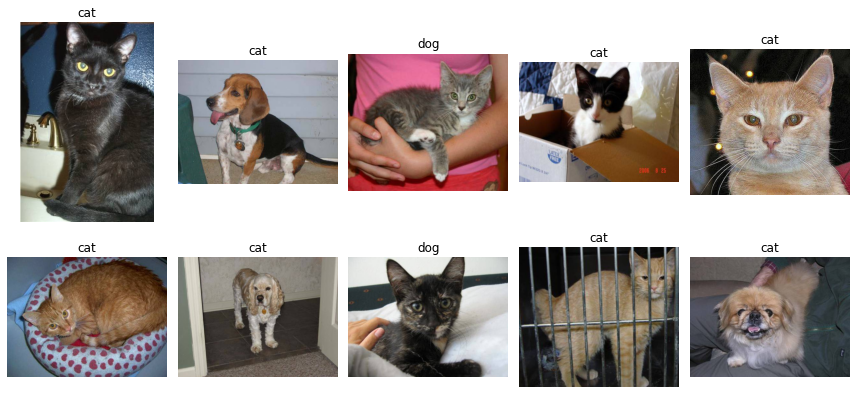

In [24]:
# (코드 6-21) 테스트 데이터셋 예측 결과 이미지 출력
display_image_grid(test_images_filepaths)

# 출력 결과를 보면 그렇게 예측 결과가 좋지는 않아보임 >> 극히 일부 데이터를 이용해서 모델 학습 진행했기 때문임
# BUT 캐글 데이터 전체를 사용하면 성능은 높아지나, CPU를 사용하면 훈련 시간은 며칠이 걸릴 수도 있음 ...

### 6.1.2. AlexNet

In [25]:
# (코드 6-22) 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
# (코드 6-23) 데이터 전처리
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [27]:
# (코드 6-24) 데이터 가져와서 훈련/검증/테스트 용으로 분리
cat_directory = r'./data/dogs-vs-cats/Cat/'
dog_directory = r'./data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10] 
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [28]:
# (코드 6-25) 커스텀 데이터셋 정의
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [29]:
# (코드 6-26) 변수(평균, 표준편차)에 대한 변수 값 정의
# AlexNet은 깊이가 깊은 네트워크를 사용하므로, 이미지 크기가 256이 아니면 풀링층 때문에 크기가 계속 줄어들어 오류 발생 가능
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [30]:
# (코드 6-27) 훈련/검증/테스트 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [31]:
# (코드 6-28) 데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

########### 여기까지 데이터 관련 준비는 완료 ###########
########### 이제 AlexNet 모델 네트워크 정의 ###########

torch.Size([32, 3, 256, 256])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1])


In [32]:
# (코드 6-29) AlexNet Model 네트워크 정의
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x 

In [33]:
# (코드 6-30) model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
# (코드 6-31) 옵티마이저 및 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [35]:
# (코드 6-32) 모델 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [36]:
# (코드 6-33) 모델 학습 함수 정의 >> LeNet와 코드 동일
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [37]:
# (코드 6-34) 모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\USER\AppData\Local\Temp\ipykernel_32456\1096881636.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5326
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5217
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5217
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6923 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5326
Training complete in 3m 4s


In [39]:
# (코드 6-35) 모델을 이용한 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('./data/alexnet.csv', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_32456\1826514766.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
# (코드 6-36) 데이터 프레임 결과 확인
res.head(10)

,id,label
0,145,0.501489
1,211,0.502519
2,162,0.501602
3,200,0.503321
4,210,0.502440
5,224,0.500993
6,213,0.501084
7,109,0.502668
8,15,0.501373
9,167,0.501061


In [41]:
# (코드 6-37) 예측 결과를 시각적으로 표현하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

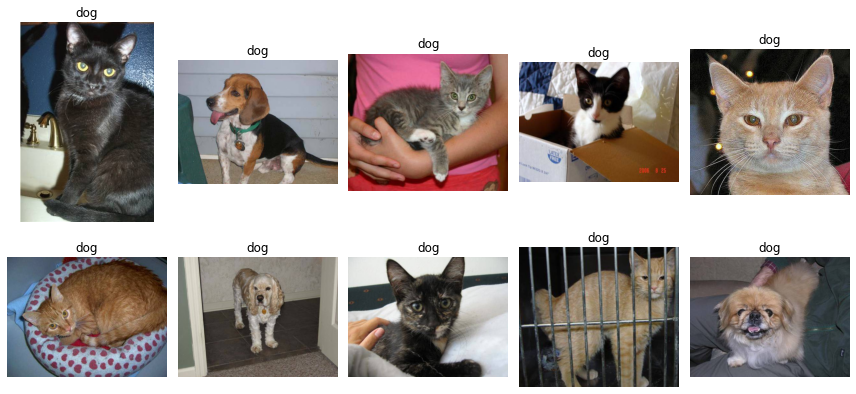

In [42]:
# (코드 6-38)
display_image_grid(test_images_filepaths)

### 6.1.3. VGGNet

In [43]:
# (코드 6-39) 필요한 라이브러리 호출
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
# (코드 6-40) VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()        
        self.features = features        
        self.avgpool = nn.AdaptiveAvgPool2d(7)        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [45]:
# (코드 6-41) 모델 유형 정의
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [46]:
# (코드 6-42) VGG 계층 정의
def get_vgg_layers(config, batch_norm):    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [47]:
# (코드 6-43) 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [48]:
# (코드 6-44) VGG11 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [50]:
# (코드 6-45) VGG11 전체에 대한 네트워크
# 개, 고양이 두 개의 클래스 사용
OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [51]:
# (코드 6-46) VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [52]:
# (코드 6-47) 이미지 데이터 전처리
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [53]:
# (코드 6-48) IamgeFolder를 이용하여 데이터셋 불러오기
train_path = './data/catanddog/train'
test_path = './data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
107


(None, None)

In [54]:
# (코드 6-49) 훈련, 검증 데이터 분할
VALID_RATIO = 0.9
# 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_train_examples = int(len(train_dataset) * VALID_RATIO)
# 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, 
                                           [n_train_examples, n_valid_examples])

In [55]:
# (코드 6-50) 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# (코드 6-51) 훈련,검증,테스트 데이터셋 수 확인
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 107


In [56]:
# (코드 6-52) 메모리로 데이터 불러오기
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_data, 
                                 # 훈련 데이터셋은 임의로 섞어서 가져옴
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, 
                                batch_size = BATCH_SIZE)

In [57]:
# (코드 6-53) 옵티마이저, 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


# (코드 6-54) 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


# (코드 6-55) 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)        
        loss = criterion(y_pred, y)       
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# (코드 6-56) 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# (코드 6-57) 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [59]:
# (코드 6-58) 모델 학습
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):    
    start_time = time.monotonic()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 13m 14s
	Train Loss: 0.702 | Train Acc: 49.26%
	 Valid. Loss: 0.694 |  Valid. Acc: 43.40%
Epoch: 02 | Epoch Time: 6m 1s
	Train Loss: 0.694 | Train Acc: 52.73%
	 Valid. Loss: 0.693 |  Valid. Acc: 45.28%
Epoch: 03 | Epoch Time: 11m 13s
	Train Loss: 0.695 | Train Acc: 52.57%
	 Valid. Loss: 0.693 |  Valid. Acc: 45.28%
Epoch: 04 | Epoch Time: 211m 9s
	Train Loss: 0.696 | Train Acc: 50.98%
	 Valid. Loss: 0.693 |  Valid. Acc: 45.28%
Epoch: 05 | Epoch Time: 43m 37s
	Train Loss: 0.704 | Train Acc: 48.32%
	 Valid. Loss: 0.694 |  Valid. Acc: 43.40%


In [60]:
# (코드 6-59) 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load('./data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.693 | Test Acc: 43.93%


In [61]:
# (코드 6-60) 테스트 데이터셋을 이용한 모델 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [62]:
# (코드 6-61) 예측 중에서 정확히 예측한 것 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [63]:
# (코드 6-62) 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


# (코드 6-63) 모델이 정확하게 예측한 이미지 출력 함수
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

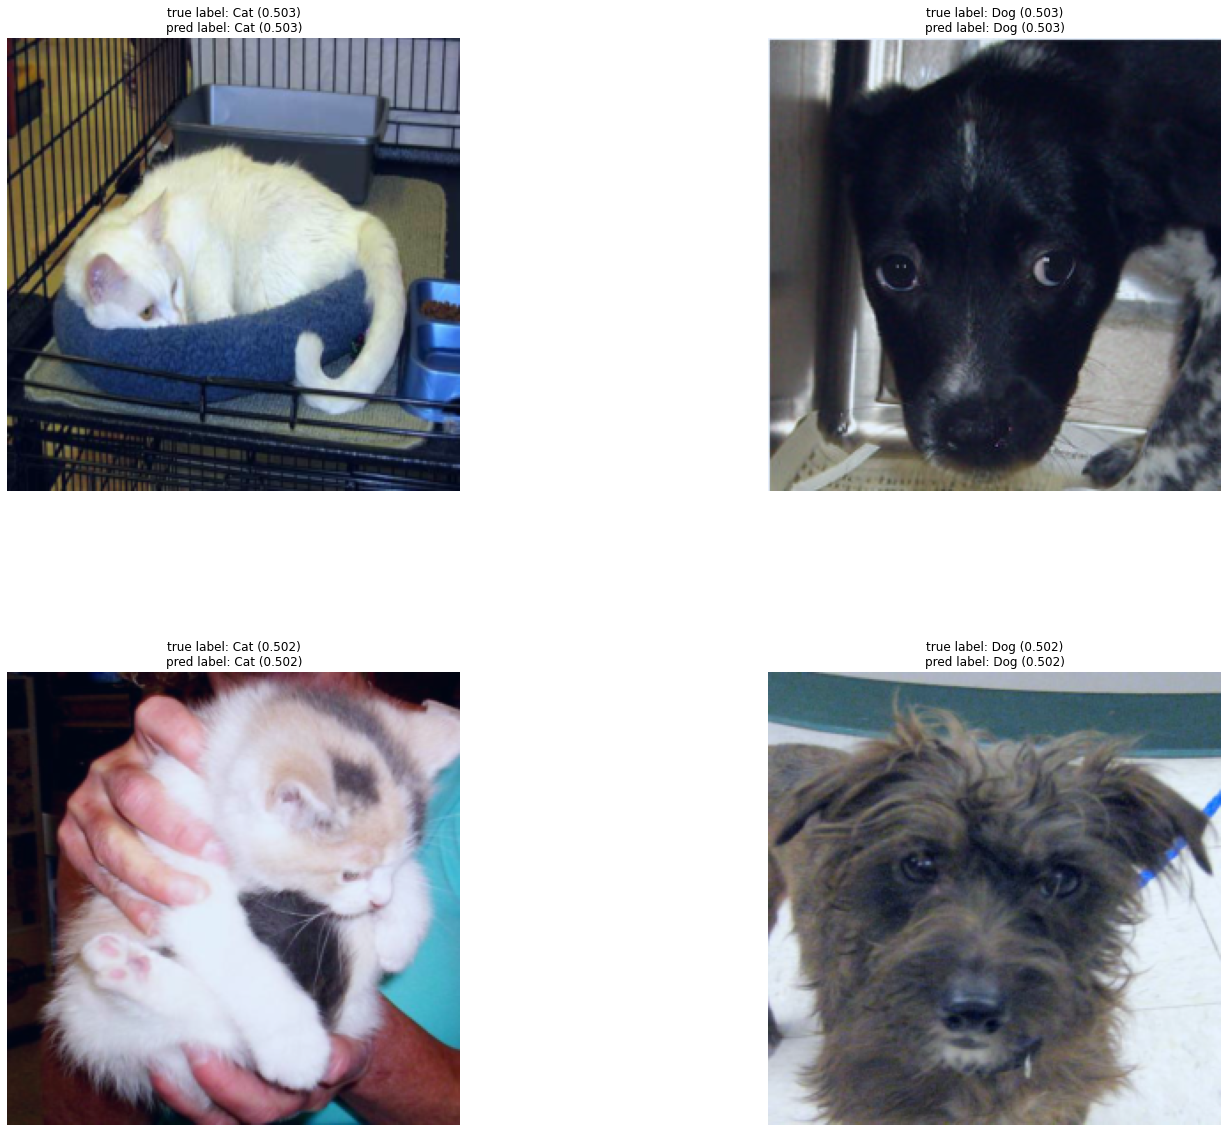

In [64]:
# (코드 6-64) 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

### 6.1.5. ResNet

In [65]:
# (코드 6-65) 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
# (코드 6-65) 이미지 데이터 전처리
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [67]:
# (코드 6-67) 변수에 대한 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [68]:
# (코드 6-68) 훈련, 테스트 데이터셋 불러오기
cat_directory = r'./data/dogs-vs-cats/Cat/'
dog_directory = r'./data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] 

In [69]:
# (코드 6-69) 데이터셋을 훈련/검증/테스트 용도로 분리
random.seed(42)    
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [70]:
# (코드 6-70) 이미지에 대한 레이블 구분
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [71]:
# (코드 6-71) 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [72]:
# (코드 6-72) 데이터셋의 데이터를 메모리로 불러오기
train_iterator  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0])


In [73]:
# (코드 6-73) 기본 블록 정의
# 기본 블록은 ResNet18, ResNet34에서 사용됨 (합성곱(3x3) 두 개로 구성됨)
class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [74]:
# (코드 6-74) 병목 블록 정의
class Bottleneck(nn.Module):    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [75]:
# (코드 6-75) ResNet 모델 네트워크
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):   
        layers = []        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)        
        return x, h

In [76]:
# (코드 6-76) ResNetConfing 정의
ResNetConfig = namedtuple("ResNetConfig", ['block', 'n_blocks', 'channels'])

In [77]:
# (코드 6-77) 기본 블록을 사용하여 ResNetConfing 정의
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [78]:
# (코드 6-78) 병목 블록을 사용하여 RestNetConfig 정의
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [79]:
# (코드 6-79) 사전 훈련된 ResNet 모델 사용
pretrained_model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [80]:
# (코드 6-80) 사전 훈련된 RestNet 네트워크 확인
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [81]:
# (코드 6-81) ResNet50 Config을 사용한 ResNet 모델 사용
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [82]:
# (코드 6-82) 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [83]:
# (코드 6-83) 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [84]:
# (코드 6-84) 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()                
        y_pred = model(x)  
        
        loss = criterion(y_pred[0], y) 
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)        
        loss.backward()        
        optimizer.step()        
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [85]:
# (코드 6-85) 모델 평가 함수 정의
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)            
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [86]:
# (코드 6-86) 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [88]:
# (코드 6-87) 모델 학습
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 30s
	Train Loss: 0.699 | Train Acc @1:  48.56% | Train Acc @5: 100.00%
	Valid Loss: 0.702 | Valid Acc @1:  48.81% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 2m 41s
	Train Loss: 0.695 | Train Acc @1:  51.68% | Train Acc @5: 100.00%
	Valid Loss: 0.702 | Valid Acc @1:  48.81% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 3m 20s
	Train Loss: 0.693 | Train Acc @1:  52.64% | Train Acc @5: 100.00%
	Valid Loss: 0.694 | Valid Acc @1:  48.81% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 3m 55s
	Train Loss: 0.688 | Train Acc @1:  55.53% | Train Acc @5: 100.00%
	Valid Loss: 0.681 | Valid Acc @1:  60.57% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 3m 51s
	Train Loss: 0.690 | Train Acc @1:  51.92% | Train Acc @5: 100.00%
	Valid Loss: 0.670 | Valid Acc @1:  57.29% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 3m 56s
	Train Loss: 0.687 | Train Acc @1:  55.77% | Train Acc @5: 100.00%
	Valid Loss: 0.672 | Valid Acc @1:  62.35% | Valid Acc @5: 100.00%
Epoch: 07 

In [89]:
# (코드 6-88) 테스트 데이터셋을 이용한 모델 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/ReNet.csv', index=False)
res.head(10)

,id,label
0,109,0.534346
1,145,0.593958
2,15,0.541385
3,162,0.518074
4,167,0.500358
5,200,0.525943
6,210,0.487313
7,211,0.509853
8,213,0.499047
9,224,0.510066


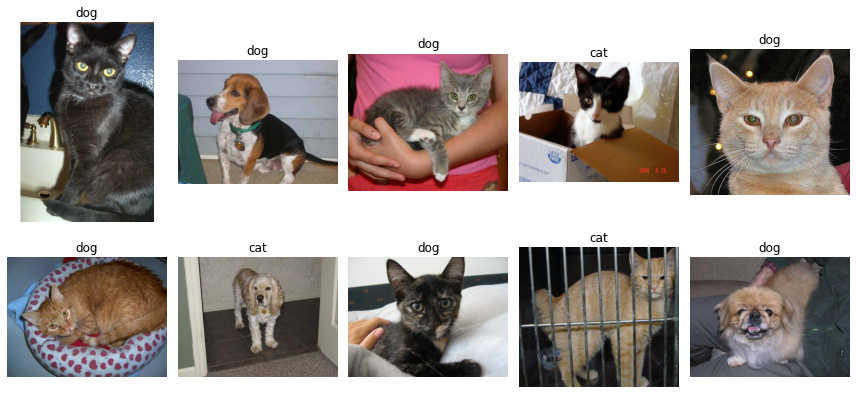

In [90]:
# (코드 6-89) 모델 예측에 대한 결과 출력
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths) 